In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from tasks import DeepSurv

ModuleNotFoundError: No module named 'tasks'

In [3]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
from pysurvival.models import BaseModel
from pysurvival import utils
import scipy
import pandas as pandas
import copy
import random
from sklearn.preprocessing import StandardScaler
from pysurvival.models.simulations import SimulationModel
from lifelines import CoxPHFitter
import pandas as pd
from sklearn.model_selection import train_test_split
import networkx as nx
from cga import cga
from itertools import cycle
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Callable, TypeVar
from sklearn.preprocessing import scale
import statsmodels.api as stats

ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/data/analysis/ag-reils/ruyogagp/envs/greg/lib/python3.9/site-packages/scipy/signal/signaltools.py)

In [4]:
# Distributions
N = 5000

distributions = {
    'binomial_a': np.random.binomial(n = 20, p = 0.6, size = N ),
    'binomial_b': np.random.binomial(n = 200, p = 0.6, size = N ),
    'chisquare': np.random.chisquare(df = 10, size = N ),
    'exponential_a': np.random.exponential(scale=0.1, size = N ),
    'exponential_b': np.random.exponential(scale=0.01, size = N ),
    'gamma': np.random.gamma(shape=2., scale=2., size = N ),
    'normal_a': np.random.normal(loc=-1.0, scale=5.0, size=N ),
    'normal_b': np.random.normal(loc=10.0, scale=10.0, size=N ),
    'uniform_a': np.random.uniform(low=-2.0, high=10.0, size=N ),
    'uniform_b': np.random.uniform(low=-20.0, high=100.0, size=N ),
    'laplace': np.random.laplace(loc=0.0, scale=1.0, size=N )
}

In [5]:
DATA_DIRECTORY = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'

## Helper Functions

In [6]:
def fit_coxph(df):
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    print(f'concordance = {cph.concordance_index_}')
    return cph

def fit_coxph_norm(df):
    standard_scaler = StandardScaler()
    for col in df.columns:
        if col == 'time' or col == 'event':
            pass
        df[col] = standard_scaler.fit_transform(df[[col]])
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()


def save_orig(df, name, output_dir):
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )
    print(f"Saved {output_dir}/{name}_train.csv")
    print(f"Saved {output_dir}/{name}_valid.csv")

def df2csv(
        df: pd.DataFrame,
        name: str,
        output_dir: str,
):
    """
    Writes csv given a dataframe + name
    """
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train_details.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid_details.csv",
        index=False,
    )

    train_df = train.loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]
    valid_df = valid.loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]
    train_df.rename(columns=dict(x_orig='x',
                                 y_orig='y',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)

    valid_df.rename(columns=dict(x_orig='x',
                                 y_orig='y',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)
    train_df.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid_df.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )

## Simulation Model with correlations

In [7]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      include_hazard: bool = False
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights)

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)


            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        print(f'scaled x shape: {X_std.shape}')
        BX = risk_function(X_std, feature_weights)

        # modify the hazard to have square risk at the 0.2 tail of the distribution
        # percentile = np.percentile(BX, [80.0])
        # BX = np.where(percentile<BX, np.square(BX), BX)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        if include_hazard:
            self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

In [8]:
def rnorm_pre(x: np.ndarray,
                          mu: float = 0.0,
                          sd: float = 1.0,
                          r: float = 0.9,
                          empirical: bool = False,
                          type: str = 'linear'):
    """
    Creates a random normally distributed array with the specified correlation
    :param x: existing array to correlate to
    :param rnorm_vector: random normal vector to transform the result to
    :param mu: desired mean of the returned array
    :param sd: desired stdev of the returned vector
    :param r: desired correlation between existing and returned vectors
    :param empirical: if true, mu, sd, and r specify the empirical not the population mean
    """
    n = len(x)
    # rnorm_vector = x + np.random.normal(loc=0.1, size=n) if type=='linear' else np.square(x)
    rnorm_vector = x + np.random.normal(loc=0.1, size=n)
    # put this as a node?
    if not empirical:
        sample_params=sample_from_population(n, mu, sd, r)
        mu = sample_params['mu']
        sd = sample_params['sd']
        r = sample_params['r']

    x = scale(x)
    e = stats.OLS(rnorm_vector, x).fit().resid
    z = r * scale(x) + np.sqrt(1-r**2) * scale(e)
    return mu + sd * z

### Correlation Case - Distribution nodes

In [9]:
@cga.node
def sample_normal_a(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal(loc=1.0, scale=5.0, size=SIZE) + noise

@cga.node
def sample_normal_b(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal(loc=10.0, scale=10.0, size=SIZE) + noise

@cga.node
def sample_gamma(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.gamma(shape=2.0, scale=2.0, size=SIZE) + noise

@cga.node
def sample_exp(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.gamma(scale=0.1, size=SIZE) + noise

@cga.node
def sample_chisq(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.chisquare(df=10, size=SIZE) + noise

@cga.node
def sample_lognormal(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.lognormal(mean=3.0, sigma=1.0, size=SIZE) + noise

### Correlation case -  operator nodes

In [10]:
@cga.node
def correlation_000(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          r=0.000)
    return correlate + noise

@cga.node
def correlation_025(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          r=0.250)
    return correlate + noise

@cga.node
def correlation_050(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          r=0.500)
    return correlate + noise

@cga.node
def correlation_070(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          type='exp',
                          r=0.700)
    return correlate + noise

@cga.node
def correlation_090(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          type='exp',
                          r=0.900)
    return correlate + noise

@cga.node
def correlation_080(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = rnorm_pre(x,
                          mu=np.mean(x),
                          sd=np.std(x),
                          empirical=True,
                          type='exp',
                          r=0.800)
    return correlate + noise

@cga.node
def noise(loc: float, scale: float) -> float:
    return np.random.normal(loc=loc, scale=scale, size=SIZE)

## Generate Data

In [18]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      include_hazard: bool = False
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights)

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)

            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            elif self.risk_type.lower() == 'lognormal':
                risk = np.exp(risk)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        print(f'scaled x shape: {X_std.shape}')
        BX = risk_function(X_std, feature_weights)
        # BX = np.exp(BX * 0.55)
        # modify the hazard to have square risk at the 0.2 tail of the distribution
        # percentile = np.percentile(BX, [80.0])
        # BX = np.where(percentile<BX, np.square(BX), BX)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)

        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        if include_hazard:
            self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset, self.baseline_hazard, self.baseline_survival

## Correlation case graph

In [19]:
class CorrelationCaseGraph(cga.Graph):
    def __init__(self):
        """œ
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        # Noise
        hidden_noise = cga.node(lambda: np.random.normal(loc=0.01, scale=0.001, size=SIZE))
        noise0 = cga.node(lambda: np.random.normal(loc=0.1, scale=0.001, size=SIZE))
        noise1 = cga.node(lambda: np.random.normal(loc=0.04, scale=0.001, size=SIZE))
        noise2 = cga.node(lambda: np.random.normal(loc=0.33, scale=0.001, size=SIZE))
        noise3 = cga.node(lambda: np.random.normal(loc=0.01, scale=0.001, size=SIZE))
        noise4 = cga.node(lambda: np.random.normal(loc=0.01, scale=0.001, size=SIZE))
        noise5  = cga.node(lambda: np.random.normal(loc=0.01, scale=0.001, size=SIZE))

        self.hidden_noise = hidden_noise(name='hidden_noise')
        self.noise0 = noise0(name="noise0")
        self.noise1 = noise1(name="noise1")
        self.noise2 = noise2(name="noise2")
        self.noise3 = noise3(name="noise3")
        self.noise4 = noise4(name="noise4")
        self.noise5 = noise5(name='noise5')

        # Features
        self.hidden_variable = sample_normal_b(self.hidden_noise, name='hidden_variable')
        self.feature0 = sample_normal_a(self.noise0, name='feature0')
        self.feature1 = sample_gamma(self.noise1, name='feature1')
        self.feature2 = sample_lognormal(self.noise2, name='feature2')
        self.feature3 = correlation_090(self.hidden_variable, self.noise3, name='feature3')
        self.feature4 = correlation_080(self.hidden_variable, self.noise4, name='feature4')
        self.feature5 = correlation_070(self.hidden_variable, self.noise5, name='feature5')
        super().__init__([self.hidden_variable, self.feature0, self.feature1, self.feature2, self.feature3, self.feature4, self.feature5])

    def get_interventions(self,
                          sim: SimulationModelWithCorrelations,
                          n_iterations: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = None
        for node in [self.noise0, self.noise1, self.noise2, self.noise3, self.noise4, self.noise5]:
            for _ in tqdm.trange(n_iterations, desc=f"Intervention {node.name}"):
                # resample noise
                orig, interventions, *_ = self.sample_do(action=cga.Resample(node), n_samples=100)
                row = {'modified_attribute': [node.name] * SIZE}
                # add orig + do to the dictionary
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})

                data = row if data == None else data
                for key in row.keys():
                    row[key] = row[key].tolist() if isinstance(row[key], np.ndarray) else row[key]
                    data[key].extend(row[key])
        intervention_df = pd.DataFrame(data)

        orig_cols = ['feature0_orig', 'feature1_orig', 'feature2_orig', 'feature3_orig', 'feature4_orig', 'feature5_orig']
        modified_attributes = [f'noise{i}' for i in range(len(orig_cols))]
        orig_df, baseline_hazard, baseline_survival = sim.generate_data(intervention_df, feature_names=orig_cols,
                                                                        feature_weights=feature_weights,
                                                                        include_hazard=True)

        # split by modified attribute, to get the input data for attribution
        attribution_dfs = self.slice_dataframe(orig_df, modified_attributes)

        intervention_df['hazard_orig'] = orig_df.hazard
        intervention_df['event_orig'] = orig_df.event
        intervention_df['time_orig'] = orig_df.time

        return attribution_dfs, intervention_df

    def slice_dataframe(self, orig_df, modified_attributes):
        df_list = []
        for modified_attribute in modified_attributes:
            df = orig_df.loc[orig_df.modified_attribute==modified_attribute]\
                      .loc[:, ['feature0_orig', 'feature1_orig', 'feature2_orig', 'feature3_orig', 'feature4_orig', 'feature5_orig', 'time', 'event']]\
                      .rename(columns=dict(feature0_orig='feature0',
                                           feature1_orig='feature1',
                                           feature2_orig='feature2',
                                           feature3_orig='feature3',
                                           feature4_orig='feature4',
                                           feature5_orig='feature5'))
            df_list.append(df)
        return df_list

## Sample from Graph

In [11]:
SIZE  = 100

In [29]:
# Sample features
data = None
correlation_graph = CorrelationCaseGraph()
for _ in tqdm.trange(1000, desc='sampling'):
    result = correlation_graph.sample()
    data = result if data is None else data
    for key in result.keys():
        result[key] = result[key].tolist() if isinstance(result[key], np.ndarray) else result[key]
        data[key].extend(result[key])
del data[correlation_graph.noise0]
del data[correlation_graph.noise1]
del data[correlation_graph.noise2]
del data[correlation_graph.noise3]
del data[correlation_graph.noise4]
del data[correlation_graph.noise5]
del data[correlation_graph.hidden_noise]

# Generate data
training_features = pd.DataFrame(data)
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=10.0,
                                      censored_parameter=1.0, survival_distribution='weibull',
                                      risk_parameter=1.4)
feature_weights = [np.log(5), np.log(1.5), np.log(0.6), np.log(1.1), np.log(1.1)]
feature_names = [correlation_graph.hidden_variable, correlation_graph.feature0, correlation_graph.feature1, correlation_graph.feature2, correlation_graph.feature3]
training_df, hazard, survival = sim.generate_data(training_features, feature_weights=feature_weights, feature_names=feature_names, include_hazard=True)

# Check correlations
training_df.corr()

sampling: 100%|██████████| 1000/1000 [00:04<00:00, 240.22it/s]


scaled x shape: (100100, 5)
Number of data-points: 100100 - Number of events: 50518.0


,hidden_variable,feature0,feature1,feature2,feature3,feature4,feature5,time,event,hazard
hidden_variable,1.000000,0.006207,0.007192,0.002608,0.900959,0.801918,0.702876,-0.171854,0.022152,0.931780
feature0,0.006207,1.000000,0.002392,-0.000523,0.007784,0.002195,0.002377,-0.045197,0.002839,0.228174
feature1,0.007192,0.002392,1.000000,-0.001762,0.003208,0.007196,0.003612,0.046337,-0.010960,-0.273938
feature2,0.002608,-0.000523,-0.001762,1.000000,0.003547,0.001199,0.005205,-0.012908,-0.001529,0.055285
feature3,0.900959,0.007784,0.003208,0.003547,1.000000,0.721774,0.633476,-0.158372,0.018686,0.850834
feature4,0.801918,0.002195,0.007196,0.001199,0.721774,1.000000,0.563587,-0.138109,0.017886,0.746105
feature5,0.702876,0.002377,0.003612,0.005205,0.633476,0.563587,1.000000,-0.121683,0.013926,0.655076
time,-0.171854,-0.045197,0.046337,-0.012908,-0.158372,-0.138109,-0.121683,1.000000,0.896641,-0.184172
event,0.022152,0.002839,-0.010960,-0.001529,0.018686,0.017886,0.013926,0.896641,1.000000,0.024217
hazard,0.931780,0.228174,-0.273938,0.055285,0.850834,0.746105,0.655076,-0.184172,0.024217,1.000000


## Create train/valid splits

In [30]:
name = 'linear_revised'
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
save_orig(training_df, name=f'{name}_master', output_dir=directory)
del training_df['hazard']
del training_df[correlation_graph.hidden_variable]
save_orig(training_df, name=f'{name}_3', output_dir=directory)
del training_df[correlation_graph.feature5]
save_orig(training_df, name=f'{name}_2', output_dir=directory)
del training_df[correlation_graph.feature4]
save_orig(training_df, name=f'{name}_1', output_dir=directory)

Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_master_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_master_valid.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_3_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_3_valid.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_2_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_2_valid.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multipli

In [16]:
"""
1. Simulate 4 independent features (min 2) -> Including one hidden variable
2. Get hazards for the time function
3. Correlate to the hidden variable, create as many as i want
4. Add this
"""

'\n1. Simulate 4 independent features (min 2) -> Including one hidden variable\n2. Get hazards for the time function\n3. Correlate to the hidden variable, create as many as i want\n4. Add this\n'

## Resample Features

In [37]:
attribution_dfs, intervention_details = correlation_graph.get_interventions(sim=sim, n_iterations=50, feature_weights=feature_weights + [2])

Intervention noise5: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


scaled x shape: (30100, 6)
Number of data-points: 30100 - Number of events: 15080.0


In [38]:
experiment_id = f'{name}_3'
for idx, df in enumerate(attribution_dfs):
    df.to_csv(f'{directory}/{experiment_id}_attribute_feature{idx}.csv', index=False)
intervention_details.to_csv(f'{directory}/{experiment_id}_attribute_details.csv', index=False)

In [39]:
experiment_id = f'{name}_2'
for idx, df in enumerate(attribution_dfs):
    del df['feature5']
    df.to_csv(f'{directory}/{experiment_id}_attribute_feature{idx}.csv', index=False)

In [40]:
experiment_id = f'{name}_1'
for idx, df in enumerate(attribution_dfs):
    del df['feature4']
    df.to_csv(f'{directory}/{experiment_id}_attribute_feature{idx}.csv', index=False)

In [76]:
f'{directory}/{experiment_id}_attribute_feature{idx}.csv'

'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_cc_attribute_feature5.csv'

In [24]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
experiment_id = 'linear_cc_3'
df = pd.read_csv(f'{directory}/{experiment_id}_attribute_details.csv')

,modified_attribute,hidden_noise_orig,hidden_variable_orig,noise0_orig,feature0_orig,noise1_orig,feature1_orig,noise2_orig,feature2_orig,noise3_orig,...,feature2_intervention99,noise3_intervention99,feature3_intervention99,noise4_intervention99,feature4_intervention99,noise5_intervention99,feature5_intervention99,hazard_orig,event_orig,time_orig
0,noise0,0.017653,15.170813,0.011412,-5.754580,0.007154,2.783774,-0.003790,28.125882,0.005072,...,28.125882,0.005072,10.572549,0.006910,11.401268,0.008446,21.563360,-1.300986,1.0,1.089189
1,noise0,0.003746,33.160414,-0.010304,-0.704998,-0.002038,13.115363,0.007668,19.196534,-0.009310,...,19.196534,-0.009310,39.078987,-0.000049,30.452957,-0.004090,40.251068,2.325772,1.0,0.720420
2,noise0,0.011308,-0.482314,0.015938,-3.644598,0.000776,7.047436,0.003100,28.492065,0.009895,...,28.492065,0.009895,4.519744,0.007404,15.645039,0.001762,-3.974598,-0.366263,1.0,1.006227
3,noise0,0.004596,10.186954,-0.001307,-0.089773,0.002534,14.878691,0.002229,65.577781,-0.000330,...,65.577781,-0.000330,7.504822,-0.006591,5.436543,0.000304,8.672189,1.356092,0.0,0.000000
4,noise0,-0.018512,19.295038,-0.003135,-0.001321,-0.001156,1.862547,0.012500,11.059373,0.002759,...,11.059373,0.002759,16.062726,0.001777,27.328293,-0.001029,22.382198,0.578517,1.0,0.907931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30095,noise5,-0.007962,19.542572,0.008811,7.215381,0.000364,4.742604,0.009107,20.812874,-0.009933,...,20.812874,-0.009933,18.853302,-0.006773,8.585719,-0.013457,10.977047,2.693682,0.0,0.000000
30096,noise5,0.012465,20.421069,-0.001468,-9.168749,0.011004,5.229583,-0.009520,22.611479,-0.013790,...,22.611479,-0.013790,17.161507,0.011066,12.387845,0.000368,22.085092,-1.764510,0.0,0.000000
30097,noise5,-0.000863,3.068828,0.009862,-2.223355,-0.011269,2.869682,-0.000093,62.228436,-0.007349,...,62.228436,-0.007349,4.285997,0.005296,-5.023684,0.000035,10.863646,-1.058377,0.0,0.902313
30098,noise5,-0.008722,18.197236,0.018369,7.297602,-0.004952,1.461313,0.002524,8.249011,-0.001455,...,8.249011,-0.001455,16.865053,0.008268,21.020876,-0.011333,17.230074,2.520339,0.0,0.000000


In [26]:
experiment_id = 'linear_decreasing_1'
lindec1 = pd.read_csv(f'{directory}/{experiment_id}_attribute_details.csv')

,modified_attribute,hidden_noise_orig,hidden_variable_orig,noise0_orig,feature0_orig,noise1_orig,feature1_orig,noise2_orig,feature2_orig,noise3_orig,...,feature2_intervention99,noise3_intervention99,feature3_intervention99,noise4_intervention99,feature4_intervention99,noise5_intervention99,feature5_intervention99,hazard_orig,event_orig,time_orig
0,noise0,-0.000219,-4.018845,-0.000925,0.459769,0.000375,2.054263,0.003606,21.707499,-0.001552,...,21.707499,-0.001552,-2.582836,-0.000640,8.397453,-0.001252,-2.895591,-0.639830,0.0,0.355173
1,noise0,-0.000437,13.183602,0.000989,-2.590031,-0.000759,1.786070,-0.000976,5.666156,-0.000554,...,5.666156,-0.000554,0.982396,-0.000282,14.980055,0.000573,7.978426,0.550207,0.0,0.000000
2,noise0,-0.000535,8.438535,0.000303,3.815417,0.001004,3.314821,0.000437,15.254534,-0.001409,...,15.254534,-0.001409,9.005955,0.000670,12.623948,0.001412,9.216486,1.229885,1.0,0.979983
3,noise0,-0.001206,0.966526,-0.001330,-0.943972,-0.000638,8.209676,0.000907,15.595776,-0.001476,...,15.595776,-0.001476,-3.042351,0.000415,0.122180,0.001654,1.836313,-2.022290,0.0,0.000000
4,noise0,0.000698,0.737595,-0.000514,7.110782,-0.000124,8.750213,0.000147,53.600089,-0.002628,...,53.600089,-0.002628,2.566127,0.002250,17.255977,0.000094,-2.641394,-0.842763,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,noise5,-0.000336,13.373477,-0.000086,-7.227700,0.000242,1.672485,0.000285,7.455531,0.002157,...,7.455531,0.002157,24.168466,-0.000116,8.363154,0.001297,18.686510,0.569217,0.0,0.000000
45096,noise5,-0.000176,20.360259,-0.000621,0.072992,-0.000172,4.230753,0.000590,14.575677,0.000971,...,14.575677,0.000971,20.452487,0.002019,22.322994,0.001077,19.235188,2.255328,1.0,0.661737
45097,noise5,0.001384,8.740631,0.001081,1.579198,0.000072,2.607460,-0.000243,11.265121,-0.002064,...,11.265121,-0.002064,5.345933,0.000113,6.884318,0.000786,1.109229,0.307098,1.0,0.878507
45098,noise5,-0.001746,13.917737,0.000302,4.645683,-0.000082,3.522157,0.001566,47.619676,-0.000359,...,47.619676,-0.000359,10.531926,0.001835,7.777520,-0.001806,19.985320,0.729415,0.0,0.000000


In [37]:
experiment_id = 'lognormal_cc_3'
lincc3 = pd.read_csv(f'{directory}/{experiment_id}_attribute_details.csv')

In [38]:
lincc3.to_csv(f'{directory}/lognormal_cc_2_attribute_details.csv')
lincc3.to_csv(f'{directory}/lognormal_cc_1_attribute_details.csv')

In [35]:
lincc3.shape

(30100, 1418)

# Simpsons Paradox Graph

In [22]:
def get_simpsons_paradox(
        p: float = 2,
        q: float = 1,
        n: float = 500,
        n_groups: int = 5,
):

    k = np.random.choice(5, size=n)
    scaling = np.random.normal(size=n)

    noise_x = np.random.normal(scale=0.25, size=n)
    noise_y = np.random.normal(scale=0.25, size=n)
    y = scaling * np.sin(p / q) + k + noise_y
    x = scaling * np.cos(p / q) + k + noise_x
    return x, y


T = TypeVar("T")


def ifnone(maybe: Optional[T], default: T) -> T:
    if maybe is None:
        return default
    else:
        return maybe


@cga.node
def simpson_x(
        scaling: float,
        group: float,
        base_noise: float,
        noise
) -> float:
    return scaling * np.cos(2 / 1) + group + base_noise + noise


@cga.node
def simpson_y(
        scaling: float,
        group: float,
        base_noise: float,
        noise: float,
) -> float:
    return scaling * np.sin(2 / 1) + group + base_noise + noise


@cga.node
def simpson_hazzard(
        scaling: float,
        group: float,
) -> float:
    return np.where((group == 2), scaling, -scaling).item()


class SimpsonsParadoxGraph(cga.Graph):
    def __init__(self):
        # define functions
        base_noise = cga.node(lambda: np.random.normal(scale=0.27))
        intervention_noise = cga.node(lambda: np.random.normal(loc=0.019, scale=0.01))
        get_group = cga.node(lambda: np.random.choice(5))
        get_scaling = cga.node(lambda: np.random.normal())

        self.base_noise0 = base_noise(name='base_noise0')
        self.base_noise1 = base_noise(name='base_noise1')
        self.noise0 = intervention_noise(name='noise0')
        self.noise1 = intervention_noise(name='noise1')
        self.group = get_group(name="group")

        self.scaling = get_scaling(name="scaling")

        self.feature0 = simpson_x(self.scaling, self.group, self.base_noise0, self.noise0, name="feature0")
        self.feature1 = simpson_y(self.scaling, self.group, self.base_noise1, self.noise1, name="feature1")

        self.hazard = simpson_hazzard(self.scaling, self.group, name="hazard")
        super().__init__([self.feature0, self.feature1, self.hazard])

    def get_interventions(self, g, sim, n_samples):
        data = []
        for node in [g.noise0, g.noise1]:
            for _ in tqdm.auto.trange(n_samples,
                                      desc=f"Intervention {node.name}"):
                orig, interventions = g.sample_do(
                    action=cga.Resample(node),
                    n_samples=100,
                )
                row = {'modified_attribute': node.name}
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})
                data.append(row)
            df = pd.DataFrame(data)
        sim_df = sim.generate_data(df, hazzard_column='hazard_orig')
        df['event_orig'] = sim_df.event
        df['time_orig'] = sim_df.time

        # separate x and y to build attribute dataframe
        xdf = df.loc[df.modified_attribute=='noise0']\
                  .loc[:, ['feature0_orig', 'feature1_orig', 'time_orig', 'event_orig']]\
            .rename(columns=dict(x_orig='x', y_orig='y', time_orig='time', event_orig='event'))
        ydf = df.loc[df.modified_attribute=='noise1']\
                  .loc[:, ['feature0_orig', 'feature1_orig', 'time_orig', 'event_orig']]\
            .rename(columns=dict(x_orig='x', y_orig='y', time_orig='time', event_orig='event'))

        return xdf, ydf, df


    def transform(
            self,
            dataset_row: pd.Series,
            set_values: dict = {},
            replace_nodes: dict = {},
    ) -> pd.Series:
        # print(dataset_row.keys())
        result = self.sample(
            set_values={
                self.scaling: dataset_row["predictive0"],
                self.group: np.digitize(
                    dataset_row["nonpredictive0"], [-1.5, -1, 0, 1, 1.5]
                ),
            },
            replace=replace_nodes,
        )
        return pd.Series(
            index=["feature0", "feature1", "event", "time"],
            data=[
                result[self.feature0],
                result[self.feature1],
                dataset_row["event"],
                dataset_row["time"],
            ],
        )

## Simulation Model with Risk

In [23]:
class SimulationModelWithRisk(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(
            self,
            dataframe: pd.DataFrame,
            hazzard_column="hazard",
    ):
        """
        Generating a dataset of simulated survival times from a given
        distribution through the hazard function using the Cox model

        Parameters:
        -----------

        * `dataframe`: **pd.Dataframe** --
            A pandas dataframe with a risk column.

        * `hazzard_column`: **str** *(default="risk")* --
            Name of the risk column.

        Returns:
        --------
        * dataset: pandas.DataFrame
            dataset of simulated survival times, event status and features


        Example:
        --------
        from pysurvival.models.simulations import SimulationModel

        # Initializing the simulation model
        sim = SimulationModel( survival_distribution = 'gompertz',
                               risk_type = 'linear',
                               censored_parameter = 5.0,
                               alpha = 0.01,
                               beta = 5., )

        # Generating N Random samples
        N = 1000
        dataset = sim.generate_data(num_samples = N, num_features=5)

        # Showing a few data-points
        dataset.head()
        """

        def risk_function(risk: np.ndarray) -> np.ndarray:
            # Choosing the type of risk
            if self.risk_type.lower() == "linear":
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == "square":
                risk = np.square(risk * self.risk_parameter)

            elif self.risk_type.lower() == "gaussian":
                risk = np.square(risk)
                risk = np.exp(-risk * self.risk_parameter)

            return risk.reshape(-1, 1)

        num_samples = len(dataframe)

        BX = risk_function(np.array(dataframe[hazzard_column]))
        BX = np.multiply(BX, 9.0)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(dataframe)
        self.dataset["time"] = time
        self.dataset["event"] = E
        self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

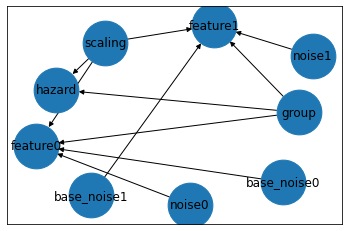

In [24]:
simpson_graph = SimpsonsParadoxGraph()
gnx = simpson_graph.to_networkx()
nx.draw_networkx(
    gnx,
    labels={n: n.name for n in gnx.nodes},
    pos=nx.layout.spring_layout(gnx, k=3),
    node_size=2_000,
)

In [25]:
n_samples = 100_000
data = []
for _ in tqdm.auto.trange(n_samples):
    result = simpson_graph.sample()
    data.append(
        {
            "feature0": result[simpson_graph.feature0],
            "feature1": result[simpson_graph.feature1],
            "hazard": float(result[simpson_graph.hazard]),
            "group": result[simpson_graph.group],
            "scaling": result[simpson_graph.scaling],
        }
    )
df = pd.DataFrame(data)
sim = SimulationModelWithRisk(risk_type='linear',
                                      alpha=1.0,
                                      beta=10.0,
                                      censored_parameter=1.5,
                                      survival_distribution='weibull')
df = sim.generate_data(df)

  0%|          | 0/100000 [00:00<?, ?it/s]

Number of data-points: 100000 - Number of events: 50998.0


In [78]:
train = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_master_train.csv')

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

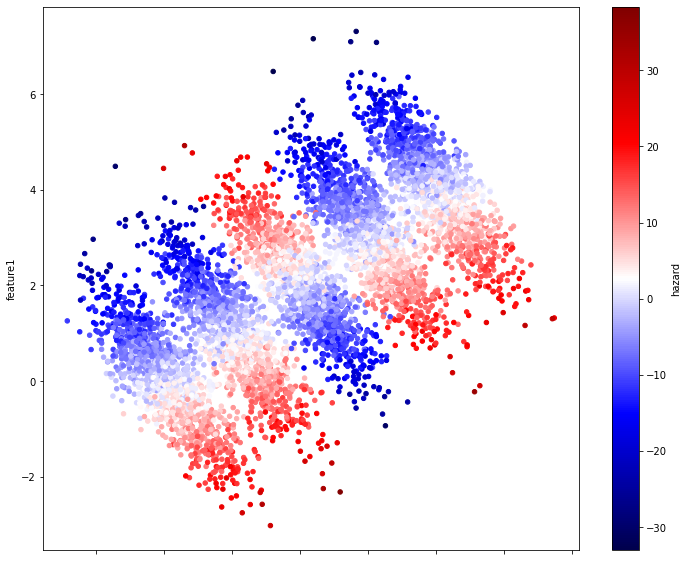

In [85]:
train.plot.scatter('feature0', 'feature1', c='hazard', cmap='seismic', figsize=(12, 10))

In [61]:
experiment_id = 'simpsons_revised'
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
save_orig(df, name=experiment_id + '_master', output_dir=directory)
training_df = df.loc[:, ['feature0', 'feature1', 'time', 'event']]
save_orig(training_df, name=experiment_id, output_dir=directory)

Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_master_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_master_valid.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_valid.csv


In [63]:
feature0_df, feature1_df, intervention_df = simpson_graph.get_interventions(simpson_graph, sim, 5000)

Intervention noise0:   0%|          | 0/5000 [00:00<?, ?it/s]

Intervention noise1:   0%|          | 0/5000 [00:00<?, ?it/s]

Number of data-points: 10000 - Number of events: 5132.0


In [64]:
feature0_df.to_csv(f'{DATA_DIRECTORY}/{experiment_id}_attribute_feature0.csv', index=False)
feature1_df.to_csv(f'{DATA_DIRECTORY}/{experiment_id}_attribute_feature1.csv', index=False)
intervention_df.to_csv(f'{DATA_DIRECTORY}/{experiment_id}_attribute_details.csv', index=False)

In [12]:
@cga.node
def relu(x: float, noise:float) -> float:
    """
    Rectified Linear unit `mul`
    """
    out = x * (x > 0)
    return out + noise

@cga.node
def tanh(x: float, noise:float) -> float:
    """
    Hyperbolic Tangent
    """
    out = np.tanh(x)
    return out + noise

@cga.node
def sigmoid(x: float, noise:float) -> float:
    """
    Sigmoid function
    """
    out = 1 / (1 + np.exp(-x))
    return out + noise

@cga.node
def square(x: float, noise:float) -> float:
    """
    Squared
    """
    out = np.square(x)
    return out + noise

@cga.node
def sample_random_normal(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal() + noise


class NonLinearCaseGraph(cga.Graph):
    def __init__(self):
        """
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        noise = cga.node(lambda: np.random.normal(scale=0.25))
        self.noise0 = noise(name="noise0")
        self.noise1 = noise(name="noise1")
        self.noise2 = noise(name="noise2")
        self.noise3 = noise(name="noise3")
        self.noise4 = noise(name="noise4")
        self.feature0 = sample_random_normal(self.noise0, name='feature0')
        self.feature1 = relu(self.feature0, self.noise1, name='feature1')
        self.feature2 = tanh(self.feature0, self.noise2, name='feature2')
        self.feature3 = sigmoid(self.feature0, self.noise3, name='feature3')
        self.feature4 = square(self.feature0, self.noise4, name='feature4')
        super().__init__([self.feature0, self.feature1, self.feature2, self.feature3, self.feature4])

    def get_interventions(self,
                          graph: any,
                          sim: SimulationModelWithCorrelations,
                          n_samples: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = []
        for node in [graph.noise0, graph.noise1, graph.noise2, graph.noise3, graph.noise4]:
            for _ in tqdm.auto.trange(n_samples,
                                      desc=f"Intervention {node.name}"):
                orig, interventions = graph.sample_do(
                    action=cga.Resample(node),
                    n_samples=100,
                )
                row = {'modified_attribute': node.name}
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})
                data.append(row)
        intervention_df = pd.DataFrame(data)

        orig_cols = ['feature0_orig', 'feature1_orig', 'feature2_orig', 'feature3_orig', 'feature4_orig']
        modified_attributes = [f'noise{i}' for i in range(len(orig_cols))]
        orig_df = sim.generate_data(intervention_df, feature_names=orig_cols,
                                    feature_weights=feature_weights,
                                    include_hazard=True)

        # split by modified attribute, to get the input data for attribution
        attribution_dfs = self.slice_dataframe(orig_df, modified_attributes)

        intervention_df['hazard_orig'] = orig_df.hazard
        intervention_df['event_orig'] = orig_df.event
        intervention_df['time_orig'] = orig_df.time

        return attribution_dfs, intervention_df

    def slice_dataframe(self, orig_df, modified_attributes):
        df_list = []
        for modified_attribute in modified_attributes:
            df = orig_df.loc[orig_df.modified_attribute==modified_attribute]\
                     .loc[:, ['feature0_orig', 'feature1_orig', 'feature2_orig', 'feature3_orig', 'feature4_orig', 'time', 'event']]\
                .rename(columns=dict(feature0_orig='feature0',
                                     feature1_orig='feature1',
                                     feature2_orig='feature2',
                                     feature3_orig='feature3',
                                     feature4_orig='feature4'))
            df_list.append(df)
        return df_list

    def test_intervention(self, n_iterations):
        for node in [self.noise_x]:
            for _ in tqdm.trange(n_iterations, desc=f"Intervention {node.name}"):
                # resample noise
                orig, intervention0, intervention1 = self.sample_do(action=cga.Resample(node))
        return orig, intervention0, intervention1

In [27]:
complete_ds

NameError: name 'complete_ds' is not defined

In [ ]:
# Sample features for training data
nonlinear_graph = NonLinearCaseGraph()
data = []
for _ in tqdm.trange(30000, desc='sampling'):
    result = nonlinear_graph.sample()
    data.append({'feature0': result[nonlinear_graph.feature0],
                 'feature1': result[nonlinear_graph.feature1],
                 'feature2': result[nonlinear_graph.feature2],
                 'feature3': result[nonlinear_graph.feature3],
                 'feature4': result[nonlinear_graph.feature4]})

# Generate data
training_features = pd.DataFrame(data)
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=10.0, censored_parameter=5.0, survival_distribution='weibull')
feature_weights = [np.log(2), np.log(1.4), np.log(1.3), np.log(1.2), np.log(1.1)]
feature_names = [f'feature{i}' for i in range(5)]
training_df = sim.generate_data(training_features, feature_weights=feature_weights, feature_names=feature_names, include_hazard=False)

In [ ]:
experiment_id = 'lr_nonlinear'
save_orig(training_df, experiment_id, output_dir=DATA_DIRECTORY)

In [ ]:
# Resample from graph
attribution_dfs, intervention_details = nonlinear_graph.get_interventions(graph=nonlinear_graph, sim=sim, n_samples=7500, feature_weights=feature_weights)

In [ ]:
experiment_id = 'lr_nonlinear'
for idx, df in enumerate(attribution_dfs):
    df.to_csv(f'{DATA_DIRECTORY}/{experiment_id}_attribute_feature{idx}.csv', index=False)
intervention_details.to_csv(f'{DATA_DIRECTORY}/{experiment_id}_attribute_details.csv', index=False)

In [ ]:
df = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_attribute_details.csv')
df = pd.read_csv('/data/analysis')

In [ ]:
df.plot.scatter('x_orig', 'y_orig', c='hazzard_orig')

In [13]:
@cga.node
def correlation_075(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = create_correlated_var(x,
                                      mu=np.mean(x),
                                      sd=np.std(x),
                                      empirical=True,
                                      r=0.750)
    return correlate + noise

class CorrelationCaseGraph2(cga.Graph):
    def __init__(self):
        """
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        noise = cga.node(lambda: np.random.normal(scale=0.01, size=100))
        self.noise0 = noise(name="noise0")
        self.noise1 = noise(name="noise1")
        self.feature0 = sample_random_normal(self.noise0, name='feature0')
        self.feature1 = correlation_075(self.feature0, self.noise1, name='feature1')
        super().__init__([self.feature0, self.feature1])

    def get_interventions(self,
                          sim: SimulationModelWithCorrelations,
                          n_iterations: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = None
        for node in [self.noise0, self.noise1]:
            for _ in tqdm.trange(n_iterations, desc=f"Intervention {node.name}"):
                # resample noise
                orig, interventions, *_ = self.sample_do(action=cga.Resample(node), n_samples=100)
                row = {'modified_attribute': [node.name] * 100}
                # add orig + do to the dictionary
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})

                data = row if data == None else data
                for key in row.keys():
                    row[key] = row[key].tolist() if isinstance(row[key], np.ndarray) else row[key]
                    data[key].extend(row[key])
        intervention_df = pd.DataFrame(data)

        orig_cols = ['feature0_orig', 'feature1_orig']
        modified_attributes = [f'noise{i}' for i in range(len(orig_cols))]
        orig_df = sim.generate_data(intervention_df, feature_names=orig_cols,
                                    feature_weights=feature_weights,
                                    include_hazard=True)

        # split by modified attribute, to get the input data for attribution
        attribution_dfs = self.slice_dataframe(orig_df, modified_attributes)

        intervention_df['hazard_orig'] = orig_df.hazard
        intervention_df['event_orig'] = orig_df.event
        intervention_df['time_orig'] = orig_df.time

        return attribution_dfs, intervention_df

    def slice_dataframe(self, orig_df, modified_attributes):
        df_list = []
        for modified_attribute in modified_attributes:
            df = orig_df.loc[orig_df.modified_attribute==modified_attribute]\
                     .loc[:, ['feature0_orig', 'feature1_orig', 'time', 'event']]\
                .rename(columns=dict(feature0_orig='feature0',
                                     feature1_orig='feature1'))
            df_list.append(df)
        return df_list

In [14]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      include_hazard: bool = False
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights )

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)


            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        BX = risk_function(X_std, feature_weights)

        # modify the hazard to have square risk at the 0.2 tail of the distribution
        # percentile = np.percentile(BX, [80.0])
        # BX = np.where(percentile<BX, np.square(BX), BX)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        if include_hazard:
            self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

In [ ]:
# Sample features
data = None
correlation_graph = CorrelationCaseGraph2()
for _ in tqdm.trange(1000, desc='sampling'):
    result = correlation_graph.sample()
    data = result if data is None else data
    for key in result.keys():
        result[key] = result[key].tolist() if isinstance(result[key], np.ndarray) else result[key]
        data[key].extend(result[key])
del data[correlation_graph.noise0]
del data[correlation_graph.noise1]

# Generate data
training_features = pd.DataFrame(data)
sim = SimulationModelWithCorrelations(risk_type='square', alpha=1.0, beta=10.0,
                                      censored_parameter=5.0, survival_distribution='weibull',
                                      risk_parameter=2.5)
feature_weights = [np.log(2), np.log(1.2)]
feature_names = [correlation_graph.feature0, correlation_graph.feature1]
training_df = sim.generate_data(training_features, feature_weights=feature_weights, feature_names=feature_names, include_hazard=False)

In [ ]:
# Resample from graph
attribution_dfs, intervention_details = correlation_graph.get_interventions(sim=sim, n_iterations=10, feature_weights=feature_weights)

In [ ]:
experiment_id = 'sqr_correlation'
save_orig(training_df, experiment_id, output_dir=DATA_DIRECTORY)
for idx, df in enumerate(attribution_dfs):
    df.to_csv(f'{directory}/{experiment_id}_attribute_feature{idx}.csv', index=False)
intervention_details.to_csv(f'{directory}/{experiment_id}_attribute_details.csv', index=False)

## Error calculation

In [15]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from source.tasks import DeepSurv

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
from source.wrappers import ForwardWrapper
import os
import seaborn as sns

ModuleNotFoundError: No module named 'riskiano.losses'

In [16]:
def load_attribute_details(experiment_id):
    dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
    path = f'{dir}/{experiment_id}_attribute_details.csv'
    details_df = pd.read_csv(path)
    return details_df, path

# TODO: this works if the second tag is the experiment identifier
def load_details(run):
    dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
    try:
        path = f'{dir}/{run.tags[0]}_attribute_details.csv'
        details_df = pd.read_csv(path)
    except:
        path = f'{dir}/{run.tags[1]}_attribute_details.csv'
        details_df = pd.read_csv(path)
    print(f'reading {path}')
    return details_df, path

def output_diff(model, orig_features, resampled_features):
    orig_output, *_ = model(orig_features)
    resampled_output, *_ = model(resampled_features)
    with torch.no_grad():
        diff = torch.sub(orig_output, resampled_output)
    return diff.detach().numpy()

# CREATE TUPLES FOR MODEL DIFF

def col2numpy(df, colname):
    """
    convert a dataframe column to a numpy array
    :param df: dataframe
    :param colname: column name to convert to numpy array
    :return:
    """
    vals = df.loc[:, colname].values.tolist()
    vals_numpy = np.array([np.array(eval(row)) for row in vals])
    return vals_numpy

def clip_norm2d(array, tail):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array: array to be normalized
    :return: normalized array
    """
    array_norm = np.zeros((array.shape))
    c_array = np.zeros((array.shape))
    for i in range(array.shape[0]):
        column = array[i, :]
        outliers = np.percentile(column, [tail, 100-tail])
        clipped_array = np.clip(column, *outliers)
        col_norm = clipped_array / abs(clipped_array).max()
        #TODO: !!!!!FIX THIS!!!!
        array_norm[i, :] = col_norm
        c_array[i, :] = clipped_array
    return  array_norm, c_array

def clip_norm1d(array, tail):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array:  array to be normalized
    :return: normalized array
    """
    outliers = np.percentile(array, [tail, 100-tail])
    clipped_array = np.clip(array, *outliers)
    array_norm = clipped_array / abs(clipped_array).max()
    return array_norm, clipped_array

def load_attributions(run, method, n_features=5):
    attribution_list = [np.genfromtxt(run.config[f'{method}_feature{idx}_path'], delimiter=',') for idx in range(n_features)]
    return attribution_list

def reject_outliers(data, m = 150.0):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    max = data[s<m].max()
    min = data[s<m].min()
    out = np.where(s<m, data, np.where(data>0, max, min))
    return out

def clip2d(array):
    clipped_array = np.zeros((array.shape))
    for i in range(array.shape[0]):
        clipped_array[i, :] = reject_outliers(array[i, :])
    return clipped_array

In [17]:
def create_resampling_df(experiment_id, n_resampling=100, n_features=6):
    """
    Modify the original resampling dataframe to create per-feature resampling df with resampling differences
    :param experiment_id: experiment identifier
    :return: None -> saves resampling dataframe
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
    run = runs[0]
    details_df, path = load_attribute_details(experiment_id)

    modified_attributes = [f'noise{idx}' for idx in range(n_features)]
    for idx in range(n_features):
        df = details_df[details_df.modified_attribute == f'noise{idx}']
        colnames = [f'feature{idx}_intervention{n}' for n in range(n_resampling)]

        # TODO
        rcolnames = [f'feature1_intervention{n}' for n in range(n_resampling)]
        rintervention_df = df.loc[:, rcolnames]
        rintervention_df['intervention'] = rintervention_df.values.tolist()

        intervention_df = df.loc[:, colnames]
        intervention_df['intervention'] = intervention_df.values.tolist()
        resampling_df = pd.DataFrame({f'feature{idx}_resampling': intervention_df.intervention,
                                      'feature1_rresampling': rintervention_df.intervention,
                                      f'feature{idx}_orig': df[f'feature{idx}_orig'],
                                      'time_orig': df.time_orig,
                                      'event_orig': df.event_orig})
        # return resampling_df, df
        for n in range(n_features):
            resampling_df[f'feature{n}_orig'] = df[f'feature{n}_orig']

        orig_vals = resampling_df.loc[:, f'feature{idx}_orig'].values
        resamp_vals = resampling_df.loc[:, f'feature{idx}_resampling'].values.tolist()
        resamp_vals_numpy=np.array([np.array(row) for row in resamp_vals])
        orig_vals_array = np.array([[val] * n_resampling for val in orig_vals])
        resampling_df.loc[:, 'resampling_diff'] = np.subtract(orig_vals_array, resamp_vals_numpy).tolist()

        # exp_id_trunc = experiment_id[:-2]
        resampling_df.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')
        print(f' wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')

In [72]:
create_resampling_df(experiment_id='simpsons_revised', n_resampling=100, n_features=2)

 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_resampling_feature0.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_resampling_feature1.csv


In [19]:
create_resampling_df(experiment_id='linear_revised_1', n_resampling=100, n_features=4)

 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_resampling_feature0.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_resampling_feature1.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_resampling_feature2.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_resampling_feature3.csv


In [43]:
create_resampling_df(experiment_id='lognormal_cc_2', n_resampling=100, n_features=5)

 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature0.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature1.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature2.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature3.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature4.csv


In [44]:
create_resampling_df(experiment_id='lognormal_cc_3', n_resampling=100, n_features=6)

 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature0.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature1.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature2.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature3.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature4.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature5.csv


In [10]:
experiment_id = 'lognormal_cc_1'
api = wandb.Api()
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

In [11]:
run=runs[0]

In [12]:
run.id

'1dg0lx0q'

In [10]:
def calculate_change_slope(experiment_id, n_features=5):
    """
    Calculates change slope for each run
    :param experiment_id: experiment identifier
    :return: None -> saves the change slope per run
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
    print(len(runs))
    for run in runs:
        for idx in range(n_features):
            resampling_df = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv', index_col=0)
            print(f'read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')
            intervention_df = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_attribute_details.csv')
            intervention_df = intervention_df[intervention_df['modified_attribute']==f'noise{idx}']
            try:
                model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])
            except:
                print(run.id)
                continue

            # create orig and resampling tensors
            orig_features = [f'feature{idx}_orig' for idx in range(n_features)]
            orig_tensor = torch.Tensor(resampling_df[orig_features].to_numpy(dtype='float64'))
            resamp_tensors = []
            resamp_vals = col2numpy(resampling_df, f'feature{idx}_resampling')
            for i_intervention in range(100):
                resamp_features = [f'feature{n}_intervention{i_intervention}' for n in range(n_features)]
                resamp_tensors.append(torch.Tensor(intervention_df.loc[:, resamp_features].to_numpy(dtype='float64')))

            # calculate model outputs
            orig_output = model(orig_tensor)[0].detach().numpy()
            resamp_outputs = None
            for i in range(resamp_vals.shape[1]):
                resamp_output = model(resamp_tensors[i])[0].detach().numpy()
                resamp_outputs = resamp_output if resamp_outputs is None else np.concatenate((resamp_outputs, resamp_output), axis=1)

            # calculate change_slope
            model_diff = np.subtract(orig_output, resamp_outputs)
            resampling_diff = col2numpy(resampling_df, 'resampling_diff')
            change_slope = np.true_divide(model_diff, resampling_diff)
            clipped_mean_cs = np.mean(clip2d(change_slope), axis=1)
            mean_cs = np.mean(change_slope, axis=1)
            median_cs = np.median(change_slope, axis=1)

            # save values in dataframe
            resampling_df.loc[:, 'orig_output'] = orig_output
            resampling_df.loc[:, 'resamp_output'] = resamp_outputs.tolist()
            resampling_df.loc[:, 'model_diff'] = model_diff.tolist()
            resampling_df.loc[:, 'change_slope'] = change_slope.tolist()
            resampling_df.loc[:, 'mean_cs'] = mean_cs
            resampling_df.loc[:, 'clipped_mean_cs'] = clipped_mean_cs
            resampling_df.loc[:, 'median_cs'] = median_cs
            methods = ['FeaturePermutation',
                       'IntegratedGradients',
                       'InputxGradient',
                       'Lime',
                       'KernelExplainer',
                       'DeepExplainer']

            try:
                for method in methods:
                    attribution_list = load_attributions(run, method, n_features=n_features)
                    resampling_df.loc[:, f'{method}_feature{idx}'] = attribution_list[idx].tolist()
            except KeyError:
                print(run.id)
                continue

            # Save dataframes
            EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'
            if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}'):
                os.mkdir(f'{EVALUATION_DIR}/{experiment_id}')

            if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}/change_slope'):
                os.mkdir(f'{EVALUATION_DIR}/{experiment_id}/change_slope')

            # very whack
            seed = int(run.config['Lime_feature0_path'].split('_')[-1][:-4])

            resampling_df.to_csv(f'{EVALUATION_DIR}/{experiment_id}/change_slope/feature{idx}_{seed}.csv')
            print(f'Wrote {EVALUATION_DIR}/{experiment_id}/change_slope/feature{idx}_{seed}.csv')

In [ ]:
calculate_change_slope('lognormal_cc_1', n_features=4)

In [8]:
calculate_change_slope('lognormal_cc_2', n_features=5)

44
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature0.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_2/change_slope/feature0_520.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature1.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_2/change_slope/feature1_520.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_2_resampling_feature2.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_2/change_slope/feature2_520.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/

In [ ]:
calculate_change_slope('lognormal_cc_3', n_features=6)

50
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature0.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_3/change_slope/feature0_526.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature1.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_3/change_slope/feature1_526.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/lognormal_cc_3_resampling_feature2.csv
Wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/lognormal_cc_3/change_slope/feature2_526.csv
read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/